In [1028]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import random
from collections import Counter

Remarque : pour déchiffrer le code secret donné il faut que vous commenciez par définir une distance V sur l'ensemble des textes. Par exemple en utilisant le fichier de données, on connait les probabilités de transitions théoriques entre deux caractères (dont l'espace).  Un texte sera donc d'autant plus probable que le produit des probabilités de transitions de ses caractères sera grand. Par ailleurs, on peut voir l'ensemble des code possibles comme des permutations de {a,b,c,...} (dont l'espace). Il faut donc trouver une manière simple de se déplacer dans cet espace, par exemple en passant d'un code à l'autre par une simple transposition. Reste ensuite à coder la méthode de recuit simulé avec cette fonction V et ce noyau de proposition.

In [1029]:
# Chargement des données
probas = np.loadtxt('transitions_alphabets.txt') #bigramme des probas
message = list(open('MSG.txt').read().strip()) # message à dechiffrer
print("message à déchiffrer ---> ", message)
alphabet = [' '] + [chr(i) for i in range(ord('A'), ord('Z')+1)] # alphabet[0]=' ' ; alphabet[1] = 'A' .... ; alphabet[26] = 'Z'
print("alphabet ---> ",alphabet)

message à déchiffrer --->  ['F', 'R', 'N', 'B', 'R', 'J', 'M', 'F', 'B', 'R', 'N', 'Q', 'X', 'H', 'F', 'Y', 'N', 'W', 'S', 'R', 'N', 'K', 'R', 'D', 'N', 'Z', 'L', 'X', 'D', 'R', 'D', 'N', 'M', 'O', 'O', 'H', 'C', 'R', 'F', 'Y', 'N', 'Z', 'X', 'J', 'J', 'R', 'N', 'Y', 'S', 'N', 'K', 'R', 'D', 'N', 'B', 'R', 'D', 'H', 'O', 'R', 'D', 'N', 'J', 'M', 'H', 'D', 'N', 'B', 'R', 'D', 'H', 'O', 'R', 'N', 'W', 'S', 'N', 'R', 'K', 'K', 'R', 'D', 'N', 'M', 'O', 'O', 'H', 'C', 'R', 'F', 'Y', 'N', 'Z', 'X', 'J', 'J', 'R', 'N', 'R', 'K', 'K', 'R', 'D', 'N', 'M', 'O', 'O', 'H', 'C', 'R', 'F', 'Y', 'N', 'R', 'Y', 'N', 'Y', 'S', 'N', 'Q', 'O', 'X', 'D', 'Q', 'R', 'O', 'R', 'O', 'M', 'D', 'N', 'Y', 'X', 'S', 'V', 'X', 'S', 'O', 'D', 'N', 'R', 'Q', 'H', 'Z', 'Y', 'R', 'Y', 'R']
alphabet --->  [' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [1030]:
# Fonction pour déchiffrer un message codé avec une permutation
def dechiffrer_message(message_code, permutation_alphabet):
    return [permutation_alphabet[alphabet.index(lettre)] for lettre in message_code]
    # alpha = alphabet[:]
    # # Création d'un dictionnaire pour la correspondance inverse entre permutation et alphabet
    # decrypt_dict = {permutation_alphabet[i]: alpha[i] for i in range(len(alpha))}
    
    # # Déchiffrer le message en remplaçant chaque caractère selon le dictionnaire
    # message_dechiffre = ''.join(decrypt_dict[char] for char in message_code)
    
    # return message_dechiffre

print(alphabet)

[' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [1031]:
# Fonction pour calculer le potentiel d'une permutation donnée
def V(message_code, permutation):

    ### Entrée : un message code, une permutation de l'alphabet, les probas de transitions, et l'alphabet
    ### Sortie : Un réel qui represente le potentiel

    val = 0
    decode = dechiffrer_message(message_code, permutation) #dechiffre le message via une permutation donnée
    for i in range(len(decode)-1): #calcul le produit des probas de transition
        lettre1 = decode[i]
        lettre2 = decode[i+1]
        #print(lettre1)
        index1 = alphabet.index(lettre1)
        index2 = alphabet.index(lettre2)
        #print(index1)
        #print(transitions[index1][index2]+1e-6)
        val += np.log(probas[index1][index2]+1e-6)
    return val/len(decode)

print(V(message, alphabet))
print(alphabet)

-8.569076353963306
[' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [1032]:
def recuit_simule_decrypt(message_code, it, h):
    ### Entrées : un message à déchiffrer, les probas de transitions, l'alphabet et un nombre d'itération max
    ### Sortie  : une permutations permettant de dechiffrer le message donné en entrée.

    etat0 = random.sample(alphabet, len(alphabet))
    etat = etat0[:]
    val_etat = []
    energie_vals = []
    val_etat.append(etat)
    for i in range(it):
        # #print(alphabet)
        # if i == int(it/4):
        #     print("un quart de la boucle")
        # if i == int(it/2):
        #     print("moitie de la boucle")
        # if i == int(3*it/4):
        #     print("trois quart de la boucle")
        etat_avant = etat[:]
        # Création d'une nouvelle permutation en échangeant deux lettres
        a, b = npr.choice(len(alphabet), 2, replace=False) # replace = true pour ne pas prendre 2 fois la meme valeur
        etat[a], etat[b] = etat[b], etat[a]

        # Calcul de l'énergie de la nouvelle permutation
        energie_etat = V(message_code, etat)
        energie_etat_avant = V(message_code, etat_avant)
        energie_vals.append(energie_etat)
        #print("etat",etat)
        #print("etat avant",etat_avant)
        T=h/np.log(i+2)
        #print(T)
        # Acceptation de la nouvelle permutation selon le critère de recuit
        #print(np.minimum(1, np.exp(-(energie_etat - energie_etat_avant) / T)))
        #print(np.exp(-(energie_etat - energie_etat_avant) / T))
        if npr.rand() < np.minimum(1, np.exp((energie_etat - energie_etat_avant) /T)):
            val_etat.append(etat[:]) 
        else: 
            etat = etat_avant[:]
        # le bloc if qui suit a été ajouté après l'écriture de cette fonction, 
        # après tatonnement et estimation du potentiel du message décodé
        if V(message_code, etat) >= -2.12:
            print("message décodé en ", i, "itération")
            break
    return val_etat, energie_vals

it = 15000 <br>
h = 0.1

message décodé en  3950 itération


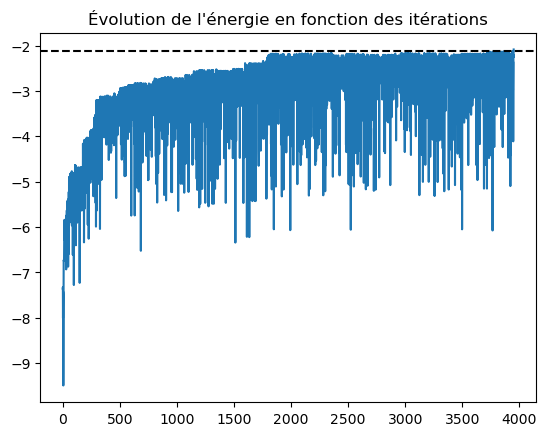

In [1033]:
# Exécution de l'algorithme
it = 7500
h = 0.1
permutions, energie_vals = recuit_simule_decrypt(message, it, h)
plt.plot(energie_vals)
plt.title("Évolution de l'énergie en fonction des itérations")
plt.axhline(y=-2.12, linestyle='--', color='k')
plt.show()

In [1034]:
final_permu = permutions[-1]
print("permutation final ---> ",final_permu)
print("potentiel du message décodé via la dernière permutation obtenue", V(message, final_permu))
message_decoder = dechiffrer_message(message, final_permu)
print(message_decoder)

permutation final --->  ['X', 'J', 'D', 'G', 'S', 'W', 'N', 'Z', 'I', 'B', 'M', 'L', 'H', 'A', ' ', 'R', 'F', 'P', 'E', 'U', 'Y', 'K', 'V', 'Q', 'O', 'T', 'C']
potentiel du message décodé via la dernière permutation obtenue -2.08478489364319
['N', 'E', ' ', 'D', 'E', 'M', 'A', 'N', 'D', 'E', ' ', 'P', 'O', 'I', 'N', 'T', ' ', 'Q', 'U', 'E', ' ', 'L', 'E', 'S', ' ', 'C', 'H', 'O', 'S', 'E', 'S', ' ', 'A', 'R', 'R', 'I', 'G', 'E', 'N', 'T', ' ', 'C', 'O', 'M', 'M', 'E', ' ', 'T', 'U', ' ', 'L', 'E', 'S', ' ', 'D', 'E', 'S', 'I', 'R', 'E', 'S', ' ', 'M', 'A', 'I', 'S', ' ', 'D', 'E', 'S', 'I', 'R', 'E', ' ', 'Q', 'U', ' ', 'E', 'L', 'L', 'E', 'S', ' ', 'A', 'R', 'R', 'I', 'G', 'E', 'N', 'T', ' ', 'C', 'O', 'M', 'M', 'E', ' ', 'E', 'L', 'L', 'E', 'S', ' ', 'A', 'R', 'R', 'I', 'G', 'E', 'N', 'T', ' ', 'E', 'T', ' ', 'T', 'U', ' ', 'P', 'R', 'O', 'S', 'P', 'E', 'R', 'E', 'R', 'A', 'S', ' ', 'T', 'O', 'U', 'V', 'O', 'U', 'R', 'S', ' ', 'E', 'P', 'I', 'C', 'T', 'E', 'T', 'E']


In [1035]:
ens_energi = []
ens_mess_fin =[]
for i in range(10):
    permutions, energie_vals = recuit_simule_decrypt(message, it, h)
    print(dechiffrer_message(message, permutions[-1]))
    print(energie_vals[-1])
    print("\n")
    ens_energi.append(energie_vals[-1])
    ens_mess_fin.append(dechiffrer_message(message, permutions[-1]))

message décodé en  4168 itération
['N', 'E', ' ', 'D', 'E', 'M', 'A', 'N', 'D', 'E', ' ', 'P', 'O', 'I', 'N', 'T', ' ', 'Q', 'U', 'E', ' ', 'L', 'E', 'S', ' ', 'C', 'H', 'O', 'S', 'E', 'S', ' ', 'A', 'R', 'R', 'I', 'V', 'E', 'N', 'T', ' ', 'C', 'O', 'M', 'M', 'E', ' ', 'T', 'U', ' ', 'L', 'E', 'S', ' ', 'D', 'E', 'S', 'I', 'R', 'E', 'S', ' ', 'M', 'A', 'I', 'S', ' ', 'D', 'E', 'S', 'I', 'R', 'E', ' ', 'Q', 'U', ' ', 'E', 'L', 'L', 'E', 'S', ' ', 'A', 'R', 'R', 'I', 'V', 'E', 'N', 'T', ' ', 'C', 'O', 'M', 'M', 'E', ' ', 'E', 'L', 'L', 'E', 'S', ' ', 'A', 'R', 'R', 'I', 'V', 'E', 'N', 'T', ' ', 'E', 'T', ' ', 'T', 'U', ' ', 'P', 'R', 'O', 'S', 'P', 'E', 'R', 'E', 'R', 'A', 'S', ' ', 'T', 'O', 'U', 'J', 'O', 'U', 'R', 'S', ' ', 'E', 'P', 'I', 'C', 'T', 'E', 'T', 'E']
-2.097564325260094


message décodé en  6725 itération
['N', 'E', ' ', 'D', 'E', 'M', 'A', 'N', 'D', 'E', ' ', 'P', 'O', 'I', 'N', 'T', ' ', 'Q', 'U', 'E', ' ', 'L', 'E', 'S', ' ', 'C', 'H', 'O', 'S', 'E', 'S', ' ', 'A', 'R',

on réussi à décoder 6 fois sur 20


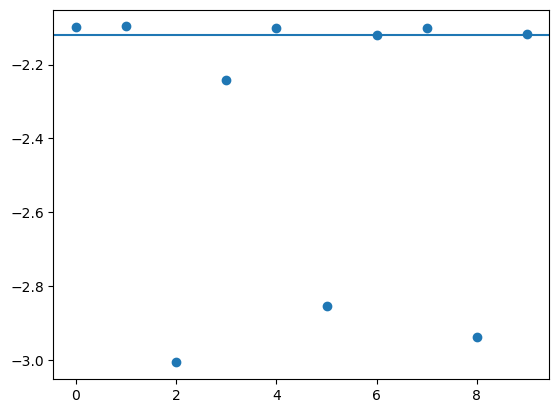

In [1036]:
plt.scatter(list(range(len(ens_energi))), ens_energi)
plt.axhline(y=-2.12)
print("on réussi à décoder", sum(np.array(ens_energi) >= -2.12), "fois sur 20")